# CMIP6 Earth System Model example

Grid-aware operations such as average, integrate and cumulative integration rely on user-provided [grid metrics](https://xgcm.readthedocs.io/en/latest/grid_metrics.html). This notebook demonstrates the methods `interp_like()`, `get_metrics()`, and `set_metric()` which makes working with metrics easier, better, faster, and shorter when processing CMIP6 Earth System Models.

## Setting up the sample dataset

First, we import the packages we need for this example.

In [1]:
import intake
import matplotlib as matplotlib
import xarray as xr
import numpy as np
import cftime
import dask

In [2]:
# Only required when working in Pangeo Cloud
!python -m pip install git+https://github.com/xgcm/xgcm.git@refs/pull/354/head
import xgcm
xgcm.__version__

  Cloning https://github.com/xgcm/xgcm.git (to revision refs/pull/354/head) to /tmp/pip-req-build-a_9kyq6r
  Running command git clone -q https://github.com/xgcm/xgcm.git /tmp/pip-req-build-a_9kyq6r
  Running command git fetch -q https://github.com/xgcm/xgcm.git refs/pull/354/head
  Running command git checkout -q 3998907ec7f8f38ace43f584a78914608be3dc16
  Running command git submodule update --init --recursive -q


'0.5.3.dev32+g3998907'

In [3]:
from dask.distributed import Client
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:38991 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


Next, we download temperature, zonal velocity and horizontal area for the GFDL-CM4 model, just one example of an [Earth System Model](https://pcmdi.llnl.gov/CMIP6/ArchiveStatistics/esgf_data_holdings/). ESMs are global, 4-dimensional, coupled ocean-atmosphere-biogeochemical models commonly used to evaluate the effects of increased atmospheric carbon dioxide concentrations on planetary processes. Check out [this page](https://www.carbonbrief.org/cmip6-the-next-generation-of-climate-models-explained) for further information. In this example, we are using historical data from 1850 to 2014, but we can change the code to download [model results from 2015 to 2100](https://www.carbonbrief.org/explainer-how-shared-socioeconomic-pathways-explore-future-climate-change) under high to low climate change mitigation scenarios, so feel free to explore! The latest version of these datasets are under CMIP6 and are hosted in the cloud by the [Pangeo project](https://pangeo.io/). 

In [4]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
cat = col.search(
    source_id = 'GFDL-CM4', # use a different source ID if you want to try other models
    member_id = 'r1i1p1f1',
    experiment_id = 'historical', # other possible inputs: ssp126, ssp370, and ssp585 
    variable_id= ['thetao','uo','areacello'],
    grid_label = 'gn',
    
)
ddict = cat.to_dataset_dict(zarr_kwargs={'consolidated':True, 'use_cftime':True}, aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [5]:
ddict.keys()

dict_keys(['CMIP.NOAA-GFDL.GFDL-CM4.historical.r1i1p1f1.Ofx.areacello.gn.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Ofx/areacello/gn/v20180701/.nan.20180701', 'CMIP.NOAA-GFDL.GFDL-CM4.historical.r1i1p1f1.Omon.uo.gn.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Omon/uo/gn/v20180701/.nan.20180701', 'CMIP.NOAA-GFDL.GFDL-CM4.historical.r1i1p1f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Omon/thetao/gn/v20180701/.nan.20180701'])

We manually extract the temperature, u-velocity and area data so we can do some renaming before we save the datasets into one array.

In [6]:
thetao = ddict['CMIP.NOAA-GFDL.GFDL-CM4.historical.r1i1p1f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Omon/thetao/gn/v20180701/.nan.20180701'].thetao
uo = ddict['CMIP.NOAA-GFDL.GFDL-CM4.historical.r1i1p1f1.Omon.uo.gn.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Omon/uo/gn/v20180701/.nan.20180701'].uo
areacello = ddict['CMIP.NOAA-GFDL.GFDL-CM4.historical.r1i1p1f1.Ofx.areacello.gn.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Ofx/areacello/gn/v20180701/.nan.20180701'].areacello

('yh', 'xh')
('time', 'lev', 'y', 'x')
('time', 'lev', 'y', 'x')


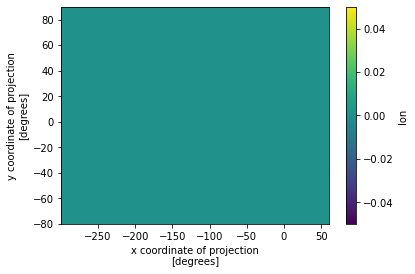

In [10]:
# Testing how uo, thetao, and areacello grid coords and dims differ
# Cell to be removed in final version

diff = uo.lon-thetao.lon
diff.plot()
print(areacello.dims)
print(uo.dims)
print(thetao.dims)

Let's rename the u-velocity dataset dimensions appropriately. Recall that the u-velocity is shifted to the right in the model grid (temperature is a tracer and considered to be in the center).

In [11]:
uo = uo.rename({'x':'x_c', 'lon':'lon_u', 'lat':'lat_u'})
areacello = areacello.rename({'xh':'x','yh':'y'})

After renaming, we can merge the datasets into one DataArray using xarray. We also assign `areacello` as a coordinate so that it can be used as a metric.

In [12]:
ds = xr.merge([thetao, uo], compat='override')
ds = ds.assign_coords(areacello=areacello.fillna(0)) # fill missing values with 0
ds

<xarray.Dataset>
Dimensions:    (lev: 35, time: 1980, x: 1440, x_c: 1440, y: 1080)
Coordinates:
    lat        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lon        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
    lat_u      (y, x_c) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lon_u      (y, x_c) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * x_c        (x_c) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
    areacello  (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
Data variables:
    thetao     (time, lev, y, x) float32 dask.array<chunksize=(1, 35, 1080, 1440), meta=np.ndarray>
    uo         (time, lev, y, x_c) float32 dask.array<chunksize=(1, 35, 1080, 1440), meta=np.ndarray>

If we look more closely, the dimensions of temperature and u-velocity are different. Take note that the metrics used for each variable when doing grid-aware operations should match. This means we can use `areacello` for temperature, but what about u-velocity? (Stay tuned!)

In [13]:
print(ds.thetao.dims)
print(ds.areacello.dims)
print(ds.uo.dims)

('time', 'lev', 'y', 'x')
('y', 'x')
('time', 'lev', 'y', 'x_c')


## Subset your preferred ocean patch from the global array `ds`

First, subset your preferred patch of ocean from the global dataset `ds`. For now it's set to the California Current, but you can adjust lat_north, lat_south, lon_west, and lon_east to your liking. GFDL-CM4 uses negative values east of the IDL (i.e., 130 W is -130), and this can vary per model so if you change `source_id` in the beginning, make sure you take note of the longitude convention used by that model.

In [14]:
lat_north = 50
lat_south = 25
lon_west = -130
lon_east = -110
subset = ds.loc[{'y':slice(lat_south,lat_north), 'x':slice(lon_west,lon_east), 'x_c':slice(lon_west,lon_east)}]
subset

<xarray.Dataset>
Dimensions:    (lev: 35, time: 1980, x: 79, x_c: 79, y: 128)
Coordinates:
    lat        (y, x) float32 dask.array<chunksize=(128, 79), meta=np.ndarray>
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lon        (y, x) float32 dask.array<chunksize=(128, 79), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * x          (x) float64 -129.8 -129.6 -129.3 -129.1 ... -110.6 -110.3 -110.0
  * y          (y) float64 25.15 25.38 25.6 25.83 ... 49.41 49.58 49.74 49.9
    lat_u      (y, x_c) float32 dask.array<chunksize=(128, 79), meta=np.ndarray>
    lon_u      (y, x_c) float32 dask.array<chunksize=(128, 79), meta=np.ndarray>
  * x_c        (x_c) float64 -129.8 -129.6 -129.3 ... -110.6 -110.3 -110.0
    areacello  (y, x) float32 dask.array<chunksize=(128, 79), meta=np.ndarray>
Data variables:
    thetao     (time, lev, y, x) float32 dask.array<chunksize=(1, 35, 128, 79), meta=np.ndarray>
    uo         (time, lev, y, x_c) float32 dask.array<chunksize=(1, 35, 128, 79), meta=np.ndarray>

Do a quick surface plot to make sure you have the correct subset!

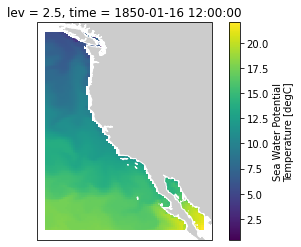

In [15]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.PlateCarree())
subset['thetao'].isel(lev=0,time=0).squeeze().plot(ax=ax)
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='w', facecolor='0.8')
ax.add_feature(coast_10m)

## Plot a time series of average surface temperature data from GFDL-CM4

Plotting the time series for temperature is straightforward since we have the metric `areacello` which has the right axes `("X","Y")` and dimensions `(x, y)`. First we create a grid object using xgcm with the right metric assigned, then xgcm can do perform grid-weighted `average` based on this grid object, which we can plot as a time series.

In [16]:
from xgcm import Grid
grid = Grid(
    subset,
    coords={
        'X':{'center':'x', 'right':'x_c'},
        'Y':{'center':'y', 'right':'y_c'},
        'Z':{'center':'lev'},
    },
    periodic=False,
    boundary='extend',
    metrics={('X','Y'): 'areacello'}
)
grid._metrics

{frozenset({'X',
            'Y'}): [<xarray.DataArray 'areacello' (y: 128, x: 79)>
  dask.array<getitem, shape=(128, 79), dtype=float32, chunksize=(128, 79), chunktype=numpy.ndarray>
  Coordinates:
    * x        (x) float64 -129.8 -129.6 -129.3 -129.1 ... -110.6 -110.3 -110.0
    * y        (y) float64 25.15 25.38 25.6 25.83 26.05 ... 49.41 49.58 49.74 49.9
  Attributes:
      cell_methods:   area: sum
      long_name:      Grid-Cell Area
      original_name:  areacello
      standard_name:  cell_area
      units:          m2]}

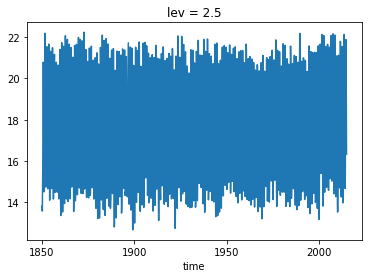

In [17]:
mean_sst = grid.average(subset.thetao.isel(lev=0),['X','Y'])
mean_sst.plot()

## Plot a time series of average surface zonal velocity data from GFDL-CM4

In previous versions of `xgcm`, trying to plot u-velocity the way we did with temperature would have failed, because we did not provide the metrics at the right dimensions. 

/srv/conda/envs/notebook/lib/python3.8/site-packages/xgcm/grid.py:1363: UserWarning: Metric at ('time', 'y', 'x_c') being interpolated from metrics at dimensions ('y', 'x'). Boundary value set to 'extend'.
  warnings.warn(


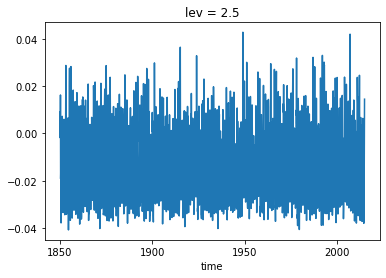

In [18]:
# I'm not sure how to show that this fails, revert to another version of xgcm at this point?
mean_uo = grid.average(subset.uo.isel(lev=0),['X','Y'])
mean_uo.plot()

To do it successfully, we would have had to do it the long way: create a `grid` object with `areacello` as a metric, interpolate the area metric to the u-velocity grid (`areacello_uo`), create another grid object with updated metrics, then calculate the `average`.

In [21]:
from xgcm import Grid
# Step 1: Create a grid object with the available metric
grid = Grid(
    subset,
    coords={
        'X':{'center':'x', 'right':'x_c'},
        'Y':{'center':'y', 'right':'y_c'},
        'Z':{'center':'lev'},
    },
    periodic=False,
    boundary='extend',
    metrics={('X','Y'): 'areacello'}
)
# Step 2: Interpolate the available metric to the desired variable grid and assign it as a coordinate
areacello_uo = grid.interp(subset.uo,("X","Y"))
subset = subset.assign_coords(areacello_uo=areacello_uo.fillna(0)) 
# Step 3: Create a new grid object 
grid_demo = Grid(
    subset,
    coords={
        'X':{'center':'x', 'right':'x_c'},
        'Y':{'center':'y', 'right':'y_c'},
        'Z':{'center':'lev'},
    },
    periodic=False,
    boundary='extend',
    metrics={('X','Y'): 'areacello_uo'}
)
# Step 4: Calculate the average and plot the time series
#mean_uo_demo = grid_demo.average(subset.uo.isel(lev=0),['X','Y'])
#mean_uo_demo.plot()

But now we can do it the short way! With the addition of `interp_like`, and updated versions of `get_metric` and `set_metrics`, we can use the exact same lines of code as we did for calculating the temperature time series (do it in 1 step vs 4 steps).

In [ ]:
mean_uo = grid.average(subset.uo.isel(lev=0),['X','Y'])
mean_uo.plot()

### Demonstrating updated functionality for the xgcm package

Let's look at little closer at how and why this worked. Since our available horizontal area metric `areacello` is in tracer dimensions, to get the metric for the u-velocity grid, we need to interpolate it to the corresponding dimensions. We can use the `interp_like` method or `get_metric`, which also uses `interp_like` "under the hood".

In [22]:
areacello_uo = grid.interp_like(subset.areacello,subset.uo)
areacello_uo_getmetric = grid.get_metric(subset.uo,("X","Y"))

/srv/conda/envs/notebook/lib/python3.8/site-packages/xgcm/grid.py:1363: UserWarning: Metric at ('time', 'lev', 'y', 'x_c') being interpolated from metrics at dimensions ('y', 'x'). Boundary value set to 'extend'.
  warnings.warn(


Double-check if the interpolated metrics are equal.

In [23]:
equal_metric = xr.testing.assert_allclose(areacello_uo,areacello_uo_getmetric)
print(equal_metric)

None


Now that we have this interpolated metric, we can update the grid object with `set_metrics`. 

In [24]:
# Step 1: Assign areacello_uo as a coordinate of subset so that you can assign it as a metric 
subset = subset.assign_coords(areacello_uo=areacello_uo.fillna(0)) # fill missing values with 0
# Step 2: Create an updated grid object
grid_updated = Grid(
    subset,
    coords={
        'X':{'center':'x', 'right':'x_c'},
        'Y':{'center':'y', 'right':'y_c'},
        'Z':{'center':'lev'},
    },
    periodic=False,
    boundary='extend',
)
# Step 3: Assign areacello_uo as a metric. 
grid_updated.set_metrics(('X','Y'),'areacello_uo')
# Step 4: Take note that you can assign multiple metrics on the same axes to your dataset as long as they have different dimensions.
grid_updated.set_metrics(('X','Y'),'areacello')
# Step 4: Double check!
grid_updated._metrics

{frozenset({'X',
            'Y'}): [<xarray.DataArray 'areacello_uo' (y: 128, x_c: 79)>
  dask.array<where, shape=(128, 79), dtype=float32, chunksize=(128, 78), chunktype=numpy.ndarray>
  Coordinates:
    * y        (y) float64 25.15 25.38 25.6 25.83 26.05 ... 49.41 49.58 49.74 49.9
    * x_c      (x_c) float64 -129.8 -129.6 -129.3 -129.1 ... -110.6 -110.3 -110.0, <xarray.DataArray 'areacello' (y: 128, x: 79)>
  dask.array<getitem, shape=(128, 79), dtype=float32, chunksize=(128, 79), chunktype=numpy.ndarray>
  Coordinates:
    * x        (x) float64 -129.8 -129.6 -129.3 -129.1 ... -110.6 -110.3 -110.0
    * y        (y) float64 25.15 25.38 25.6 25.83 26.05 ... 49.41 49.58 49.74 49.9
  Attributes:
      cell_methods:   area: sum
      long_name:      Grid-Cell Area
      original_name:  areacello
      standard_name:  cell_area
      units:          m2]}

Take note that if you just want to do grid-aware operations such as `average`, `integrate` and `cumint`, they already use `get_metric` internally. There's no need to update the metrics through `set_metrics`, this is just to show how this method can give you a level of flexibility when you are experimenting with getting the right metrics for your dataset.

### Try plotting temperature and u-velocity time series with the updated grid object.

In [ ]:
mean_sst = grid_updated.average(subset.thetao.isel(lev=0),['X','Y'])
mean_sst.plot()

In [ ]:
mean_uo = grid_updated.average(subset.uo.isel(lev=0),['X','Y'])
mean_uo.plot()

In [ ]:
![](https://media.giphy.com/media/FZuRP6WaW5qg/giphy.gif